## libs

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
from typing import List
from matplotlib import pyplot as plt
import imageio
import glob
import tensorflow as tf
import spektral
import warnings
warnings.filterwarnings('ignore', category=UserWarning)


In [2]:
import sys
sys.path.append(r'C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages')

import mediapipe as mp

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

## Build Data Loading Functions


In [5]:


def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Normalize the pixel values to the range [0, 1]
        frame = frame / 255.0
        
        # Convert the frame to grayscale with better contrast
        frame = tf.image.rgb_to_grayscale(frame)
        
        # Adjust the coordinates to better capture the lip area
        cropped_frame = frame[120:200, 60:200]  # Adjusted coordinates
        frames.append(cropped_frame)
    cap.release()
    
    # Convert list to a TensorFlow tensor for further operations if needed
    frames_tensor = tf.convert_to_tensor(frames, dtype=tf.float32)
    mean = tf.math.reduce_mean(frames_tensor)
    std = tf.math.reduce_std(frames_tensor)
    
    return tf.cast((frames_tensor - mean), tf.float32) / std





In [6]:
import mediapipe as mp
import cv2
import numpy as np

# Initialize MediaPipe FaceMesh with static_image_mode=True to process individual frames
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.7)

import cv2
import numpy as np
import mediapipe as mp

def detect_refined_lip_landmarks(frame):
    """
    Detects facial landmarks for both the outer and inner lips using Mediapipe's Face Mesh model.
    
    :param frame: The input video frame (BGR format from OpenCV).
    :return: The coordinates of lip landmarks.
    """
    mp_face_mesh = mp.solutions.face_mesh
    with mp_face_mesh.FaceMesh() as face_mesh:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = face_mesh.process(rgb_frame)

        # Indices for upper and lower lips
        upper_lip_indices = [61, 185, 40, 39, 37, 0, 267, 269, 270, 191, 80, 81, 82, 13, 312, 311, 310]
        lower_lip_indices = [146, 91, 181, 84, 17, 314, 405, 321, 78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308]

        lip_landmarks = []

        if result.multi_face_landmarks:
            face_landmarks = result.multi_face_landmarks[0]

            # Collect the upper lip landmarks
            for idx in upper_lip_indices:
                x = int(face_landmarks.landmark[idx].x * frame.shape[1])
                y = int(face_landmarks.landmark[idx].y * frame.shape[0])
                lip_landmarks.append([x, y])

            # Collect the lower lip landmarks
            for idx in lower_lip_indices:
                x = int(face_landmarks.landmark[idx].x * frame.shape[1])
                y = int(face_landmarks.landmark[idx].y * frame.shape[0])
                lip_landmarks.append([x, y])

    return np.array(lip_landmarks)

def process_video_for_refined_lip_landmarks(video_path, expected_landmark_count=36):
    """
    Processes a video to detect precise lip landmarks.
    Pads the frames where the number of landmarks is fewer than expected, or fills with zeros if no landmarks are found.
    Returns a NumPy array of landmarks for each frame in the video.
    """
    cap = cv2.VideoCapture(video_path)
    video_landmarks = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        lip_landmarks = detect_refined_lip_landmarks(frame)

        # If no landmarks are detected, create an empty array with expected size
        if lip_landmarks.size == 0:
            lip_landmarks = np.zeros((expected_landmark_count, 2), dtype=np.float32)

        # If fewer landmarks are detected, pad with zeros
        elif lip_landmarks.shape[0] < expected_landmark_count:
            padding = np.zeros((expected_landmark_count - lip_landmarks.shape[0], 2), dtype=np.float32)
            lip_landmarks = np.vstack([lip_landmarks, padding])

        video_landmarks.append(lip_landmarks)

    cap.release()

    # Convert list of landmarks to a NumPy array with consistent shape
    return np.array(video_landmarks, dtype=np.float32)

# Example usage:
video_path = r'C:\Users\ADMIN\Desktop\LRW-AR\train\اتفاق\00004745_اتفاق.mp4'  # Replace with your dataset video file

# Process video and get the list of landmarks
landmarks_list = process_video_for_refined_lip_landmarks(video_path)
# Print the shape of the landmarks array
print("Landmarks for the first frame:", landmarks_list)



Landmarks for the first frame: [[[124. 165.]
  [125. 164.]
  [127. 163.]
  ...
  [152. 163.]
  [154. 162.]
  [157. 161.]]

 [[123. 164.]
  [124. 163.]
  [126. 161.]
  ...
  [151. 162.]
  [153. 161.]
  [155. 161.]]

 [[122. 162.]
  [123. 161.]
  [125. 159.]
  ...
  [150. 160.]
  [152. 160.]
  [154. 159.]]

 ...

 [[102. 155.]
  [103. 153.]
  [105. 151.]
  ...
  [132. 151.]
  [134. 151.]
  [137. 150.]]

 [[102. 154.]
  [103. 152.]
  [105. 151.]
  ...
  [132. 151.]
  [134. 151.]
  [136. 149.]]

 [[102. 154.]
  [103. 152.]
  [105. 150.]
  ...
  [132. 151.]
  [134. 150.]
  [136. 149.]]]


In [7]:
import cv2
import mediapipe as mp

def visualize_lip_landmarks_on_video_with_output(video_path, output_path):
    """
    Visualizes the detected lip landmarks (upper and lower lips) on each frame of the video and saves the output video.
    
    :param video_path: Path to the input video file.
    :param output_path: Path to the output video file.
    """
    # Initialize Mediapipe Face Mesh
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5)

    # Initialize drawing utility
    mp_drawing = mp.solutions.drawing_utils
    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1, color=(0, 255, 0))

    # Indices for upper and lower lips
    upper_lip_indices = [61, 185, 40, 39, 37, 0, 267, 269, 270, 191, 80, 81, 82, 13, 312, 311, 310]
    lower_lip_indices = [146, 91, 181, 84, 17, 314, 405, 321, 78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308]

    # Open the input video file
    cap = cv2.VideoCapture(video_path)

    # Get video information
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for the output video
    fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frame rate of the input video
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Width of the input video frames
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Height of the input video frames

    # Initialize VideoWriter to write the output video
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to RGB as Mediapipe works with RGB images
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process the frame to detect landmarks
        result = face_mesh.process(rgb_frame)

        if result.multi_face_landmarks:
            for face_landmarks in result.multi_face_landmarks:
                # Draw the upper lip landmarks
                for idx in upper_lip_indices:
                    x = int(face_landmarks.landmark[idx].x * frame.shape[1])
                    y = int(face_landmarks.landmark[idx].y * frame.shape[0])
                    cv2.circle(frame, (x, y), 1, (0, 255, 0), -1)  # Green dots for upper lip

                # Draw the lower lip landmarks
                for idx in lower_lip_indices:
                    x = int(face_landmarks.landmark[idx].x * frame.shape[1])
                    y = int(face_landmarks.landmark[idx].y * frame.shape[0])
                    cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)  # Red dots for lower lip

        # Write the frame with lip landmarks to the output video
        out.write(frame)

    # Release the video capture, video writer, and close any OpenCV windows
    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Example usage

output_path = "output_video_with_lip_landmarks2.mp4"
visualize_lip_landmarks_on_video_with_output(video_path, output_path)


In [8]:
vocab = [x for x in "ابتثجحخدذرزسشصضطظعغفقكلمنهويأإآءئةىًٌٍَُِّْٰ1234567890"]



In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'أ', 'إ', 'آ', 'ء', 'ئ', 'ة', 'ى', 'ً', 'ٌ', 'ٍ', 'َ', 'ُ', 'ِ', 'ّ', 'ْ', 'ٰ', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] (size =55)


In [10]:
char_to_num.get_vocabulary()

['',
 'ا',
 'ب',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ف',
 'ق',
 'ك',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'ي',
 'أ',
 'إ',
 'آ',
 'ء',
 'ئ',
 'ة',
 'ى',
 'ً',
 'ٌ',
 'ٍ',
 'َ',
 'ُ',
 'ِ',
 'ّ',
 'ْ',
 'ٰ',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '0']

In [11]:
char_to_num(['ب',
 'ت',
 'ث',
 'ج',])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([2, 3, 4, 5], dtype=int64)>

In [13]:
with open(r"C:\Users\ADMIN\Desktop\LRW-AR\labels.txt",'r',encoding='utf-8')as f: 
        lines = f.readlines() 
print(lines)

['إن\n', 'اتفاق\n', 'الأمم\n', 'الأمن\n', 'الأميركية\n', 'الأنباء\n', 'الإسرائيلي\n', 'الإسلامية\n', 'الإيراني\n', 'البلاد\n', 'التحالف\n', 'التركي\n', 'الجزيرة\n', 'الجيش\n', 'الحكومة\n', 'الحوثي\n', 'الخارجية\n', 'الدفاع\n', 'الدولة\n', 'الدولي\n', 'الذي\n', 'الرئيس\n', 'الروسي\n', 'السعودية\n', 'السلام\n', 'السورية\n', 'الشعبية\n', 'الشيخ\n', 'العاصمة\n', 'العام\n', 'العراق\n', 'العراقية\n', 'القوات\n', 'اللقاء\n', 'الله\n', 'المتحدة\n', 'المتحدث\n', 'المجلس\n', 'المعارضة\n', 'المقاومة\n', 'الموجز\n', 'النظام\n', 'الوزراء\n', 'الوطني\n', 'الولايات\n', 'اليمن\n', 'اليمنية\n', 'اليوم\n', 'بأن\n', 'باسم\n', 'بشأن\n', 'بعد\n', 'بكم\n', 'بن\n', 'تنظيم\n', 'جنوب\n', 'جهته\n', 'حلب\n', 'دونالد\n', 'رئيس\n', 'شخصا\n', 'شمال\n', 'صالح\n', 'طائرات\n', 'عبد\n', 'عدد\n', 'عسكرية\n', 'على\n', 'علي\n', 'عليكم\n', 'عن\n', 'غارات\n', 'في\n', 'قال\n', 'قالت\n', 'قتل\n', 'قتلوا\n', 'قطر\n', 'قناة\n', 'قوات\n', 'للجزيرة\n', 'لم\n', 'ليبيا\n', 'ما\n', 'مجلس\n', 'محافظة\n', 'محمد\n', 'مدينة\n', 'مراسل\n

In [14]:
len(lines)

100

CREATION DE LABELS POUR NAVIGUER LES DOSSIERS

In [15]:
# Removing the newline character from each string
labels = [word.strip() for word in lines]

# Display the cleaned list
print(labels)



['إن', 'اتفاق', 'الأمم', 'الأمن', 'الأميركية', 'الأنباء', 'الإسرائيلي', 'الإسلامية', 'الإيراني', 'البلاد', 'التحالف', 'التركي', 'الجزيرة', 'الجيش', 'الحكومة', 'الحوثي', 'الخارجية', 'الدفاع', 'الدولة', 'الدولي', 'الذي', 'الرئيس', 'الروسي', 'السعودية', 'السلام', 'السورية', 'الشعبية', 'الشيخ', 'العاصمة', 'العام', 'العراق', 'العراقية', 'القوات', 'اللقاء', 'الله', 'المتحدة', 'المتحدث', 'المجلس', 'المعارضة', 'المقاومة', 'الموجز', 'النظام', 'الوزراء', 'الوطني', 'الولايات', 'اليمن', 'اليمنية', 'اليوم', 'بأن', 'باسم', 'بشأن', 'بعد', 'بكم', 'بن', 'تنظيم', 'جنوب', 'جهته', 'حلب', 'دونالد', 'رئيس', 'شخصا', 'شمال', 'صالح', 'طائرات', 'عبد', 'عدد', 'عسكرية', 'على', 'علي', 'عليكم', 'عن', 'غارات', 'في', 'قال', 'قالت', 'قتل', 'قتلوا', 'قطر', 'قناة', 'قوات', 'للجزيرة', 'لم', 'ليبيا', 'ما', 'مجلس', 'محافظة', 'محمد', 'مدينة', 'مراسل', 'مصادر', 'من', 'منطقة', 'مواقع', 'نحو', 'وأصيب', 'وذلك', 'وزارة', 'وزير', 'وقوات', 'وكالة']


In [16]:
video_shape=load_video(r'C:\Users\ADMIN\Desktop\LRW-AR\train\اتفاق\00004809_اتفاق.mp4')
print(f"Video shape: {tf.shape(video_shape)}")  # Output: (num_frames, frame_height, frame_width, num_channels)


Video shape: [ 36  80 140   1]


In [17]:


def load_transcriptions(file_path: str) -> List[str]:
    tokens = []
    transcriptions = pd.read_csv(file_path)

    for _, row in transcriptions.iterrows():
        tokens.append(row['word'])  # Append the word
        tokens.append(' ')  # Add a space after each word

    tokens_str = ''.join(tokens).strip()
    char_tokens = tf.strings.unicode_split(tokens_str, input_encoding='UTF-8')
    numeric_tokens = char_to_num(tf.reshape(char_tokens, (-1,)))

    return numeric_tokens  # Return without skipping any tokens


In [18]:
import tensorflow as tf
import os



def load_data(path: str):
    # Extract filename and directory from the path
    file_name = os.path.basename(path).split('.')[0]
    dir_path = os.path.dirname(path)

    # Construct video and alignment paths
    video_path = os.path.join(dir_path, f'{file_name}.mp4')
    alignment_path = os.path.join(dir_path, f'{file_name}.csv')

    # Load the video frames
    frames = load_video(video_path)
    if frames is None or len(frames) == 0:
        raise ValueError(f"No frames found or failed to load video at {video_path}")

    # Load the alignment data
    alignments = load_transcriptions(alignment_path)
    if alignments is None or len(alignments) == 0:
        raise ValueError(f"No alignments found or failed to load alignments at {alignment_path}")

    return frames, alignments



In [19]:
string=r'C:\Users\ADMIN\Desktop\LRW-AR\train\اتفاق\00007208_اتفاق.mp4'

In [20]:
frames, alignments = load_data(string)

In [21]:
alignments.shape

TensorShape([9])

In [22]:
frames.shape

TensorShape([30, 80, 140, 1])

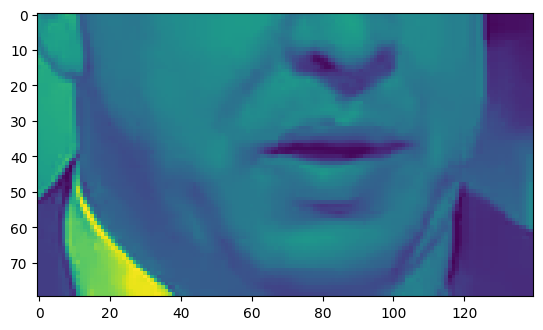

In [23]:
plt.imshow(frames[0])

In [24]:
alignments

<tf.Tensor: shape=(9,), dtype=int64, numpy=array([ 1,  3, 20,  1, 21,  0, 18, 23, 35], dtype=int64)>

In [25]:
# Join the decoded characters with a space in between
decoded_string = tf.strings.reduce_join(
    [tf.compat.as_str_any(x) + ' ' for x in num_to_char(alignments).numpy()]
)

# Convert to NumPy and decode
final_string = decoded_string.numpy().decode('utf-8').strip()

# Print the result
print(final_string)
##output tandim dawla

ا ت ف ا ق  ع ل ى


In [26]:
def load_landmarks_data(path: str):
    """
    Load facial landmarks and corresponding transcription (alignment) data from the provided path.

    :param path: The full path to the video file (e.g., video_001.mp4).
    :return: A tuple containing the landmarks tensor and corresponding transcriptions.
    """
    file_name = os.path.basename(path).split('.')[0]
    dir_path = os.path.dirname(path)

    # Construct video and alignment paths
    video_path = os.path.join(dir_path, f'{file_name}.mp4')
    alignment_path = os.path.join(dir_path, f'{file_name}.csv')

    # Load the video frames and get the landmarks
    landmarks = process_video_for_refined_lip_landmarks(video_path)
    if landmarks is None or len(landmarks) == 0:
        raise ValueError(f"No landmarks found or failed to load video at {video_path}")

    # Convert the landmarks to a TensorFlow tensor
    landmarks_tensor = tf.convert_to_tensor(landmarks, dtype=tf.float32)

    # Load the alignment data (assuming the load_transcriptions function is implemented)
    alignments = load_transcriptions(alignment_path)
    if alignments is None or len(alignments) == 0:
        raise ValueError(f"No alignments found or failed to load alignments at {alignment_path}")

    return landmarks_tensor, alignments




In [27]:
lm,al=load_landmarks_data(string)

In [28]:
lm.shape

TensorShape([30, 36, 2])

In [29]:
al.shape

TensorShape([9])

## DATA PIPELINE for conv3D 

In [30]:
def mappable_function(path: tf.Tensor) -> tuple:
    def wrapped_load_data(path):
        path_str = path.numpy().decode('utf-8')
        frames, alignments = load_data(path_str)  # load_data must return consistent shapes
        
       
        
        # Ensure the frames have the correct shape, add a channel dimension if necessary
        if frames.ndim == 3:  # If frames are (38, 40, 80), add a channel
            frames = frames[..., np.newaxis]  # Shape becomes (38, 40, 80, 1)
        return frames, alignments

    frames, alignments = tf.py_function(wrapped_load_data, [path], [tf.float32, tf.int64])

    # Set the shapes explicitly
    frames.set_shape([38,  80, 140, 1])  # Ensure frames have the correct shape
    alignments.set_shape([29])

    return frames, alignments




In [34]:
selected_labels = labels[0:100]

max_sequence_length = 38  # Maximum sequence length for frames
max_alignment_length = 29  # Maximum length for alignments

print(selected_labels)
base_path = r'C:\Users\ADMIN\Desktop\LRW-AR\train'

# Generate list of file paths
file_paths = []
for label in selected_labels:
    pattern = f'{base_path}\\{label}\\*.mp4'
    file_paths.extend(glob.glob(pattern))
    
trainset = tf.data.Dataset.from_tensor_slices(file_paths)
trainset = trainset.shuffle(100, reshuffle_each_iteration=False)
trainset = trainset.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)
trainset = trainset.padded_batch(
    batch_size=2,
    padded_shapes=([max_sequence_length,  80, 140, 1], [max_alignment_length])
)
trainset = trainset.prefetch(tf.data.AUTOTUNE)


['إن', 'اتفاق', 'الأمم', 'الأمن', 'الأميركية', 'الأنباء', 'الإسرائيلي', 'الإسلامية', 'الإيراني', 'البلاد', 'التحالف', 'التركي', 'الجزيرة', 'الجيش', 'الحكومة', 'الحوثي', 'الخارجية', 'الدفاع', 'الدولة', 'الدولي', 'الذي', 'الرئيس', 'الروسي', 'السعودية', 'السلام', 'السورية', 'الشعبية', 'الشيخ', 'العاصمة', 'العام', 'العراق', 'العراقية', 'القوات', 'اللقاء', 'الله', 'المتحدة', 'المتحدث', 'المجلس', 'المعارضة', 'المقاومة', 'الموجز', 'النظام', 'الوزراء', 'الوطني', 'الولايات', 'اليمن', 'اليمنية', 'اليوم', 'بأن', 'باسم', 'بشأن', 'بعد', 'بكم', 'بن', 'تنظيم', 'جنوب', 'جهته', 'حلب', 'دونالد', 'رئيس', 'شخصا', 'شمال', 'صالح', 'طائرات', 'عبد', 'عدد', 'عسكرية', 'على', 'علي', 'عليكم', 'عن', 'غارات', 'في', 'قال', 'قالت', 'قتل', 'قتلوا', 'قطر', 'قناة', 'قوات', 'للجزيرة', 'لم', 'ليبيا', 'ما', 'مجلس', 'محافظة', 'محمد', 'مدينة', 'مراسل', 'مصادر', 'من', 'منطقة', 'مواقع', 'نحو', 'وأصيب', 'وذلك', 'وزارة', 'وزير', 'وقوات', 'وكالة']


In [35]:
len(trainset)

7988

In [36]:
for batch in trainset.take(5):
    print(batch[0].shape)  
    print(batch[1].shape)  


(2, 38, 80, 140, 1)
(2, 29)
(2, 38, 80, 140, 1)
(2, 29)
(2, 38, 80, 140, 1)
(2, 29)
(2, 38, 80, 140, 1)
(2, 29)
(2, 38, 80, 140, 1)
(2, 29)


In [38]:
max_frames = 0
max_alignments = 0

for frames, alignments in trainset.take(2):
    max_frames = max(max_frames, frames.shape[1])
    max_alignments = max(max_alignments, alignments.shape[1])

print(f"Max frames length: {max_frames}")
print(f"Max alignments length: {max_alignments}")


Max frames length: 38
Max alignments length: 29


In [39]:
f,a=trainset.as_numpy_iterator().next()

In [40]:
trainset.as_numpy_iterator().next()[0][0].shape

(38, 80, 140, 1)

In [41]:
a

array([[21, 27,  1,  3,  0,  1, 23,  5, 28, 13,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [29, 25,  0, 12, 23,  1, 23, 34,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [42]:
sample = trainset.as_numpy_iterator()

In [43]:
val = sample.next(); val[0]

array([[[[[-2.1072621 ],
          [-2.1368985 ],
          [-1.6913946 ],
          ...,
          [ 0.9347669 ],
          [ 0.741838  ],
          [ 1.4234763 ]],

         [[-2.077626  ],
          [-2.1368985 ],
          [-1.8988497 ],
          ...,
          [ 0.87549394],
          [ 0.77147424],
          [ 1.5420222 ]],

         [[-2.077626  ],
          [-2.0479894 ],
          [-2.106305  ],
          ...,
          [ 0.7450299 ],
          [ 0.9670115 ],
          [ 1.6190135 ]],

         ...,

         [[-2.1112812 ],
          [-2.348373  ],
          [-2.4492004 ],
          ...,
          [ 0.1610983 ],
          [ 0.2793239 ],
          [ 0.45714256]],

         [[-2.301018  ],
          [-2.4788365 ],
          [-2.4785166 ],
          ...,
          [ 0.08990728],
          [ 0.22037104],
          [ 0.3981897 ]],

         [[-2.4492004 ],
          [-2.5084732 ],
          [-2.508153  ],
          ...,
          [-0.02863863],
          [ 0.1610983 ],
          

In [44]:
val[0][1].shape

(38, 80, 140, 1)

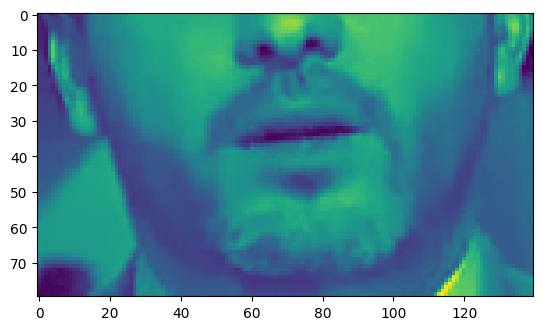

In [45]:
plt.imshow(val[0][0][17])

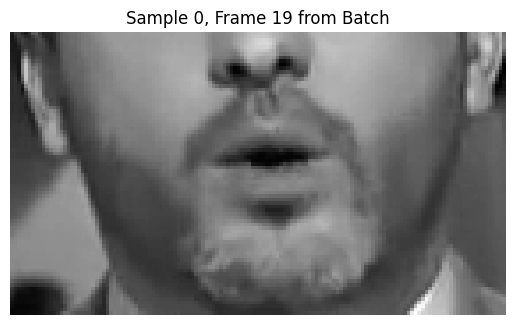

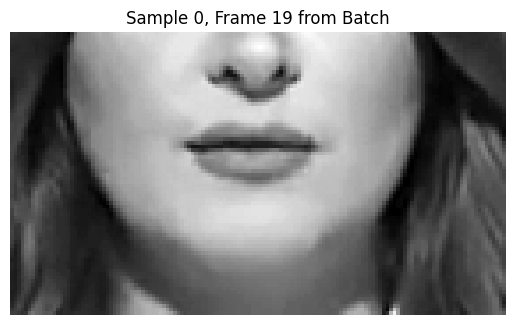

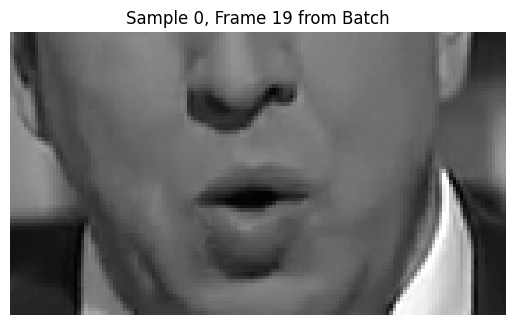

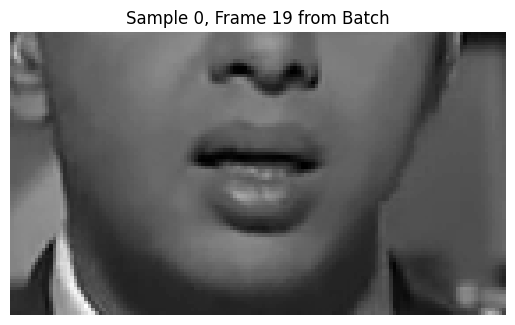

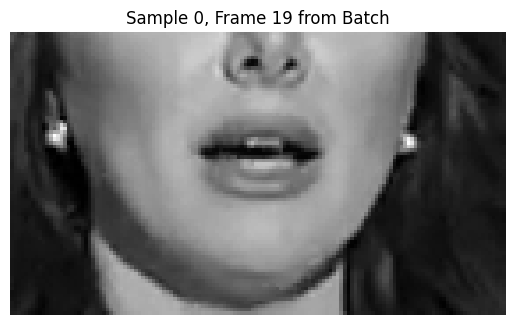

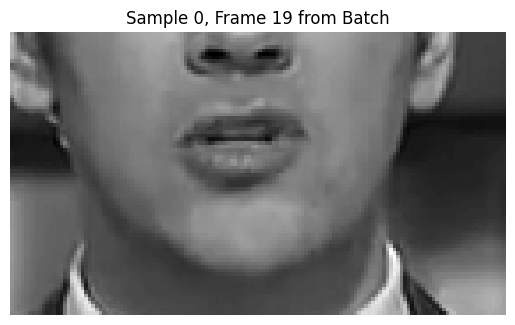

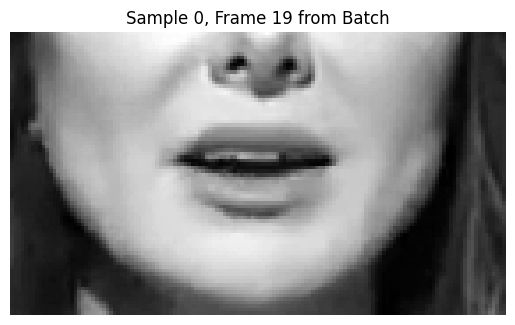

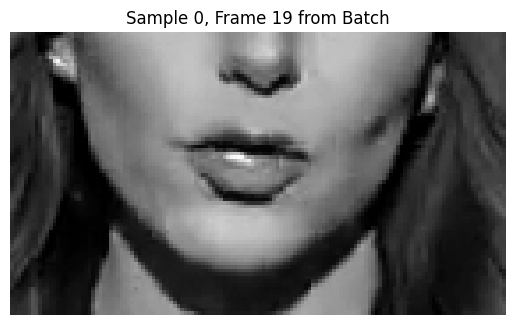

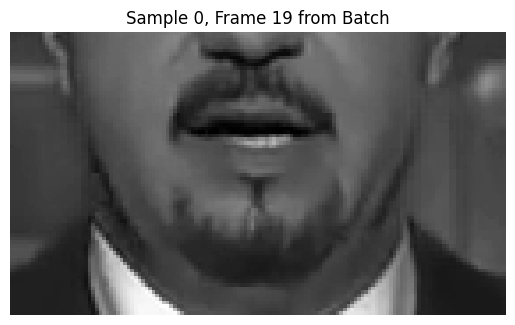

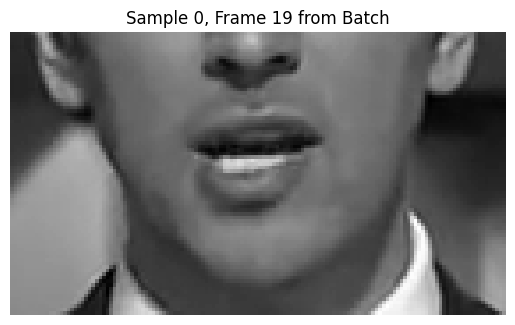

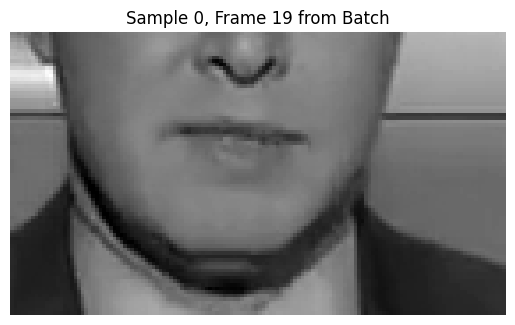

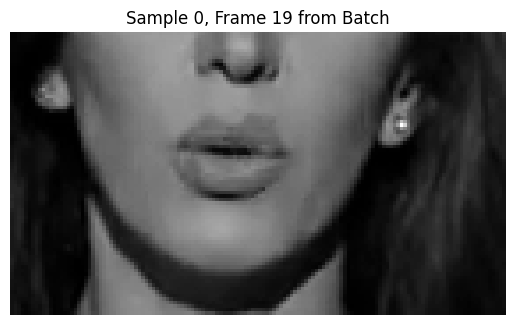

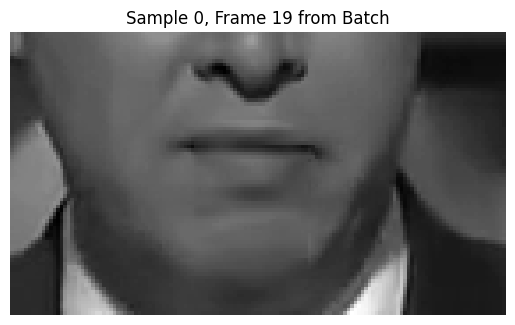

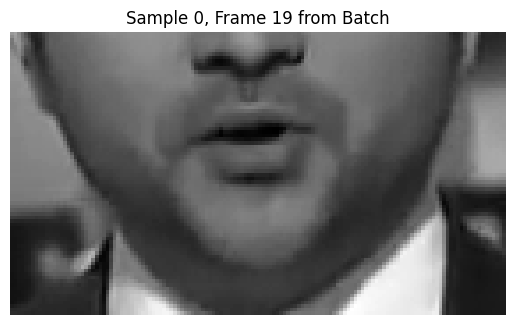

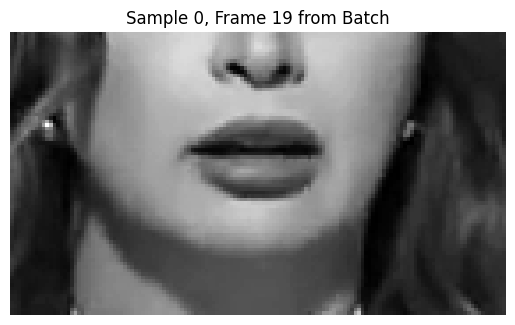

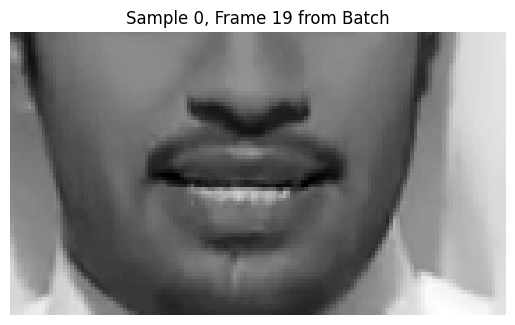

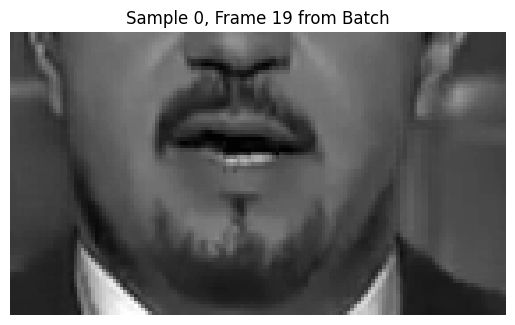

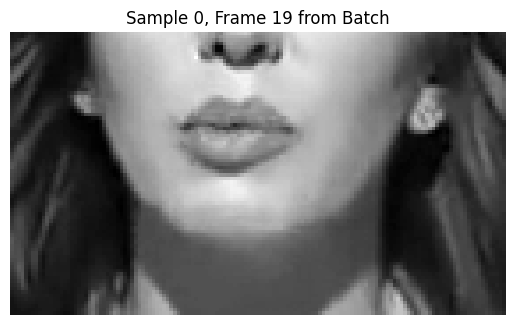

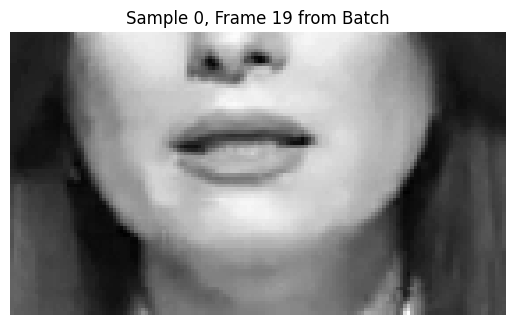

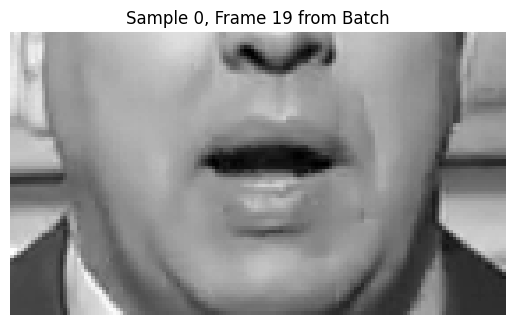

In [46]:
##showing all the lips

import matplotlib.pyplot as plt
import tensorflow as tf

# Assuming `trainset` is your dataset that outputs frames and alignments
for batch_frames, batch_alignments in trainset.take(20):
    # Loop over the batch (batch_size frames)
    for i in range(batch_frames.shape[0]):  # Loop through each sample in the batch
        video_frames = batch_frames[i]  # Get the frames for the i-th sample in the batch
        
        # Select a single frame from each video in the batch (e.g., the middle frame)
        middle_frame_idx = video_frames.shape[0] // 2  # Select the middle frame (or any other index)
        frame = video_frames[middle_frame_idx]  # Get the middle frame
        
        # Convert to numpy array for visualization if needed
        frame_np = frame.numpy()
        
        # If the frame is grayscale (1 channel), squeeze to remove the extra channel dimension
        if frame_np.shape[-1] == 1:
            frame_np = frame_np.squeeze()
        
        # Display the frame using matplotlib
        plt.imshow(frame_np, cmap='gray')  # You can change cmap='gray' to any other colormap like 'viridis'
        plt.title(f"Sample {i}, Frame {middle_frame_idx} from Batch")
        plt.axis('off')  # Turn off the axis
        plt.show()

        # Break after showing one frame from each video in the batch
        break  # Comment this line if you want to process more videos in the batch


           

In [47]:
base_path2 = r'C:\Users\ADMIN\Desktop\LRW-AR\test'

# Generate list of file paths
file_paths2 = []
for label in selected_labels:
    pattern2 = f'{base_path2}\\{label}\\*.mp4'
    file_paths2.extend(glob.glob(pattern2))
    
testset = tf.data.Dataset.from_tensor_slices(file_paths2)
testset = testset.shuffle(100, reshuffle_each_iteration=False)
testset = testset.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)
testset = testset.padded_batch(
    batch_size=2,
    padded_shapes=([max_sequence_length,  80, 140, 1], [max_alignment_length])
)
testset = testset.prefetch(tf.data.AUTOTUNE)


In [48]:
sample2 = testset.as_numpy_iterator()

In [ ]:
val2 = sample2.next(); val2[0]

In [ ]:
val2[0][1].shape

In [ ]:
plt.imshow(val2[0][0][17])

In [ ]:
##showing all the lips

import matplotlib.pyplot as plt
import tensorflow as tf

# Assuming `trainset` is your dataset that outputs frames and alignments
for batch_frames, batch_alignments in testset:
    # Loop over the batch (batch_size frames)
    for i in range(batch_frames.shape[0]):  # Loop through each sample in the batch
        video_frames = batch_frames[i]  # Get the frames for the i-th sample in the batch
        
        # Select a single frame from each video in the batch (e.g., the middle frame)
        middle_frame_idx = video_frames.shape[0] // 2  # Select the middle frame (or any other index)
        frame = video_frames[middle_frame_idx]  # Get the middle frame
        
        # Convert to numpy array for visualization if needed
        frame_np = frame.numpy()
        
        # If the frame is grayscale (1 channel), squeeze to remove the extra channel dimension
        if frame_np.shape[-1] == 1:
            frame_np = frame_np.squeeze()
        
        # Display the frame using matplotlib
        plt.imshow(frame_np, cmap='gray')  # You can change cmap='gray' to any other colormap like 'viridis'
        plt.title(f"Sample {i}, Frame {middle_frame_idx} from Batch")
        plt.axis('off')  # Turn off the axis
        plt.show()

        # Break after showing one frame from each video in the batch
        break  # Comment this line if you want to process more videos in the batch



In [76]:
 len(testset)

995

In [ ]:
# Get the first batch from the iterator
batch_from_testset = testset.as_numpy_iterator().next()
batch_from_trainset = trainset.as_numpy_iterator().next()

# Get the first sequence from the batch (which removes the batch dimension)
single_sequence_from_testset = batch_from_testset[0][0]  # Accessing first sequence
single_sequence_from_trainset = batch_from_trainset[0][0]  # Accessing first sequence

# Print the shape of the single sequence
print(single_sequence_from_testset.shape)  # Should be (38, 40, 80, 1)
print(single_sequence_from_trainset.shape)  # Should be (38, 40, 80, 1)


In [ ]:
def decode_alignments(alignments):
    # Convert Tensor to NumPy if it's a TensorFlow Tensor
    if isinstance(alignments, tf.Tensor):
        alignments = alignments.numpy()

    # # Decode each integer to a character (assuming it's valid UTF-8 encoded)
    # decoded_chars = [chr(x) for x in alignments if x > 0]  # Assuming 0 or negative values are placeholders

    # # Join the characters into a final string
    # final_string = ''.join(decoded_chars)

    decoded_string = tf.strings.reduce_join(
    [tf.compat.as_str_any(x) + ' ' for x in num_to_char(alignments).numpy()]
)

# Convert to NumPy and decode
    final_string = decoded_string.numpy().decode('utf-8').strip()

    
    return final_string

In [ ]:
da=decode_alignments(val[1][1])

In [ ]:
da

## relu / gat dataset

In [51]:
import tensorflow as tf
import numpy as np

def mappable_function1(path: tf.Tensor) -> tuple:
    """
    This function loads landmarks and alignments, ensuring they are padded to consistent shapes.
    Frames are padded to have a maximum of 38, and alignments are padded to 29, without changing the landmark shape (36, 2).
    """

    def wrapped_load_data1(path):
        # Convert TensorFlow tensor to a numpy string (path to the video)
        path_str = path.numpy().decode('utf-8')
        
        # Load the landmarks and alignments from the dataset
        landmarks, alignments = load_landmarks_data(path_str)  # Assumes load_landmarks_data returns consistent shapes

        # Ensure landmarks have the shape (num_frames, 36, 2)
        num_frames = landmarks.shape[0]

        # If the number of frames is less than 38, pad with zeros
        if num_frames < 38:
            padding = np.zeros((38 - num_frames, 36, 2), dtype=np.float32)
            landmarks = np.vstack([landmarks, padding])

        # If alignments length is less than 29, pad with zeros
        if len(alignments) < 29:
            alignments = np.pad(alignments, (0, 29 - len(alignments)), 'constant')

        return landmarks, alignments

    # Use tf.py_function to wrap the NumPy function in a TensorFlow graph-compatible function
    landmarks, alignments = tf.py_function(func=wrapped_load_data1, inp=[path], Tout=[tf.float32, tf.int64])

    # Set the shapes explicitly: landmarks should have (38, 36, 2), alignments should have (29,)
    landmarks.set_shape([38, 36, 2])
    alignments.set_shape([29])

    return landmarks, alignments





# Creating the landmark dataset

landmark_dataset = tf.data.Dataset.from_tensor_slices(file_paths)
landmark_dataset = landmark_dataset.map(mappable_function1, num_parallel_calls=tf.data.AUTOTUNE)

# Apply padded batching to handle variable-length landmarks and frames
padded_landmark_dataset = landmark_dataset.shuffle(buffer_size=100).padded_batch(
    batch_size=2,  # Adjust batch size as needed
    padded_shapes=([38, 36, 2], [29]),  # None means dynamic size for frames and landmarks
    padding_values=(tf.constant(0.0, dtype=tf.float32), tf.constant(0, dtype=tf.int64))  # Padding values for landmarks and alignments
)

# Prefetch to improve performance
padded_landmark_dataset = padded_landmark_dataset.prefetch(tf.data.AUTOTUNE)





In [52]:
len(padded_landmark_dataset)

7988

In [ ]:
# Créer un itérateur à partir de padded_landmark_dataset
# iterator = padded_landmark_dataset.as_numpy_iterator()

# # Boucle while pour itérer sur l'ensemble des données
# while True:
#     try:
#         # Obtenez le prochain élément du dataset
#         data = iterator.next()

#         # Accédez aux données (inputs et targets)
#         inputs, targets = data

#         print(targets)

#         # Si vous voulez afficher le premier exemple dans ce batch :
#         print("First target (decoded):", decode_alignments(targets[1]))
#         print("First target (decoded):", decode_alignments(targets[0]))
#     except StopIteration:
#         # Si l'itération est terminée, on arrête la boucle
#         print("Fin de l'itération sur le dataset.")
#         break


In [53]:
landmark_dataset1 = tf.data.Dataset.from_tensor_slices(file_paths2)
landmark_dataset1 = landmark_dataset1.map(mappable_function1, num_parallel_calls=tf.data.AUTOTUNE)

# Apply padded batching to handle variable-length landmarks and frames
padded_landmark_dataset1 = landmark_dataset1.shuffle(buffer_size=100).padded_batch(
    batch_size=2,  # Adjust batch size as needed
    padded_shapes=([38, 36, 2], [29]),  # None means dynamic size for frames and landmarks
    padding_values=(tf.constant(0.0, dtype=tf.float32), tf.constant(0, dtype=tf.int64))  # Padding values for landmarks and alignments
)

# Prefetch to improve performance
padded_landmark_dataset1 = padded_landmark_dataset1.prefetch(tf.data.AUTOTUNE)



In [54]:
len(padded_landmark_dataset1)

995

## model gat

In [55]:
print(padded_landmark_dataset1.as_numpy_iterator().next()[0][0].shape)
print(padded_landmark_dataset1.as_numpy_iterator().next()[0][0].shape)

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define model parameters
num_units = 128           # Number of units in LSTM layer
embedding_dim = 256       # Dimension of the embedding layer
vocab_size = 56           # Size of vocabulary for transcription
max_seq_length = 29       # Length of the output transcription sequence

# Attention mechanism layer
class AttentionLayer(layers.Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# Define the model
def build_model():
    # Input layer for landmark sequence (38 frames, 36 landmarks, 2 coordinates)
    landmark_input = layers.Input(shape=(38, 36, 2))

    # Masking layer to skip padding values
    masked_input = layers.Masking(mask_value=0.0)(landmark_input)

    # Use TimeDistributed to apply Conv1D over the landmarks at each timestep
    x = layers.TimeDistributed(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))(masked_input)
    x = layers.TimeDistributed(layers.Flatten())(x)

    # First LSTM layer with dropout for regularization
    lstm_out, forward_h, forward_c = layers.LSTM(num_units, return_sequences=True, return_state=True, dropout=0.3)(x)

    # Attention layer to focus on the important frames
    attention = AttentionLayer(num_units)
    context_vector, attention_weights = attention(forward_h, lstm_out)

    # Fully connected layer
    x = layers.Dense(embedding_dim, activation='relu')(context_vector)

    # Repeat the output vector to match the required output sequence length
    x = layers.RepeatVector(max_seq_length)(x)

    # Decoder LSTM with dropout
    x = layers.LSTM(num_units, return_sequences=True, dropout=0.3)(x)

    # Output layer to predict a word from the vocabulary at each time step
    output = layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))(x)

    # Define the model
    model = tf.keras.Model(inputs=landmark_input, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

# Instantiate the updated model
model = build_model()

# Print the model summary
model.summary()


In [ ]:
model.input_shape

In [ ]:
model.output_shape

In [ ]:
from tensorflow.keras.callbacks import Callback
import tensorflow as tf

class DisplayPredictionsCallback(Callback):
    def __init__(self, validation_data, num_to_char, padding_value=0):
        self.validation_data = validation_data
        self.num_to_char = num_to_char  # Function to convert indices to characters
        self.padding_value = padding_value  # Define the padding value to ignore (usually 0)

    def on_epoch_end(self, epoch, logs=None):
        # Display epoch statistics
        print(f"\nEpoch {epoch+1}:")
        print(f"Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")
        print(f"Validation Loss: {logs['val_loss']:.4f}, Validation Accuracy: {logs['val_accuracy']:.4f}")

        # Take one batch from the validation set
        for batch in self.validation_data.take(1):
            inputs, targets = batch
            predictions = self.model.predict(inputs)  # Predict on the batch

            # Convert targets and predictions to readable format, ignoring padding
            original_indices = [x for x in targets[0].numpy() if x != self.padding_value]  # Remove padding
            original = decode_alignments(original_indices)  # Decode target sequence

            # Get predicted indices, ignoring padding
            predicted_indices = tf.argmax(predictions[0], axis=-1).numpy()
            predicted_indices = [x for x in predicted_indices if x != self.padding_value]  # Remove padding
            predicted = decode_alignments(predicted_indices)  # Decode predicted sequence

            # Display original and predicted sequences
            print(f"Original transcription: {original}")
            print(f"Predicted transcription: {predicted}\n")
            print("Predicted logits for each step:", predictions[0])
            print("Predicted indices:", predicted_indices)

# Assuming you already have the `decode_alignments` and `num_to_char` functions defined


In [ ]:

# Assuming you have a valid `num_to_char` function that converts integers to characters
display_predictions_callback = DisplayPredictionsCallback(padded_landmark_dataset1, num_to_char)

# Training the model
history = model.fit(
    padded_landmark_dataset,   # Training data
    epochs=20,                 # Number of epochs
    validation_data=padded_landmark_dataset1,  # Test data for validation
    verbose=1,                 # Verbosity mode
    callbacks=[display_predictions_callback]   # Add the callback here
)

## deep neural network



In [56]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [57]:
testset.as_numpy_iterator().next()[0][0].shape

(38, 80, 140, 1)

In [58]:
trainset.as_numpy_iterator().next()[0][0].shape

(38, 80, 140, 1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 38, 80, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 38, 80, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 38, 40, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 38, 40, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 38, 40, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 38, 20, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 38, 20, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 38, 20, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 38, 10, 17, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 38, 12750)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masking (Masking)                    │ (None, 38, 12750)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 38, 256)             │      13,188,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 38, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 38, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 38, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 38, 56)              │          14,392 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,003,779 (57.23 MB)

 Trainable params: 15,003,779 (57.23 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
5*10*75

3750

In [61]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


In [62]:
df=tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

In [63]:
df


<tf.Tensor: shape=(), dtype=string, numpy=b'\xd9\x8b\xd9\x8b\xd9\x8b666666666666666666\xd8\xb9\xd8\xb9\xd8\xb9\xd8\xb9\xd8\xb9\xd8\xb9\xd8\xb9\xd8\xb9\xd8\xb9\xd9\x8c\xd9\x8c\xd9\x8c\xd9\x8c'>

In [64]:
final_string = df.numpy().decode('utf-8')
print(final_string)

ًًً666666666666666666عععععععععٌٌٌٌ


In [65]:
df1=tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]]).numpy().decode('utf-8')
df1

'ًًً666666666666666666عععععععععٌٌٌٌ'

In [66]:
model.input_shape

(None, 38, 80, 140, 1)

In [67]:
model.output_shape

(None, 38, 56)

## training

In [68]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [69]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.compat.v1.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss




In [70]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        
        # Get the batch size dynamically
        batch_size = tf.shape(yhat)[0].numpy()  # Get the number of samples in the batch
        sequence_lengths = [38] * batch_size  # Set sequence length (assuming 38 frames per sample)
        
        # Decode predictions using CTC decode
        decoded = tf.keras.backend.ctc_decode(yhat, sequence_lengths, greedy=False)[0][0].numpy()
        
        for x in range(batch_size):  # Loop through each sample in the batch
            print('Original:', decode_alignments(data[1][x]))  # Use your custom function to decode
            print('Prediction:', decode_alignments(decoded[x]))  # Decode predictions using the same function
            print('~'*100)



In [71]:
model.compile(optimizer=Adam(learning_rate=1e-6), loss=CTCLoss)


In [72]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpointlip.weights.h5'), monitor='loss', save_weights_only=True) 

In [73]:
schedule_callback = LearningRateScheduler(scheduler)

In [74]:
example_callback = ProduceExample(testset)

In [77]:
model.fit(trainset, validation_data=testset, epochs=2000, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/2000
   7/7988 ━━━━━━━━━━━━━━━━━━━━ 39:43:49 18s/step - loss: inf

KeyboardInterrupt: 

In [ ]:
for frames, alignments in testset.take(1):
    print(f"Frames shape: {frames.shape}")  # Should print (batch_size, 38, 40, 80, 1)
    print(f"Alignments shape: {alignments.shape}")  # Should print (batch_size, 29)
for frames, alignments in trainset.take(1):
    print(f"frames shape: {frames.shape}")
    print(f"alignments shape: {alignments.shape}")


In [ ]:
class FusionNet(nn.Module):
    def __init__(self, conv3d_model, gat_model, fusion_dim):
        super(FusionNet, self).__init__()
        self.conv3d = conv3d_model  # Modèle Conv3D
        self.gat = gat_model  # Modèle GAT
        self.fc_fusion = nn.Linear(conv3d_model.output_dim + gat_model.output_dim, fusion_dim)
        self.fc_output = nn.Linear(fusion_dim, num_classes)
        self.relu = nn.ReLU()

    def forward(self, video_input, landmark_input):
        # Extraire les caractéristiques vidéo avec Conv3D
        video_features = self.conv3d(video_input)
        
        # Extraire les caractéristiques géométriques avec GAT
        landmark_features = self.gat(landmark_input)
        
        # Fusion des caractéristiques avec concaténation
        fused_features = torch.cat((video_features, landmark_features), dim=1)
        
        # Passer les caractéristiques fusionnées dans une couche fully-connected
        fusion_output = self.relu(self.fc_fusion(fused_features))
        
        # Passer dans une couche dense pour la classification finale
        output = self.fc_output(fusion_output)
        
        return output
